In [1]:
import random
import imageio
import numpy as np
from argparse import ArgumentParser
import copy
import torch.nn.functional as F

import pandas as pd

from torch.autograd import grad

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.transforms import Compose, ToTensor, Lambda
from sklearn.model_selection import train_test_split


**Goal of this task**

To use real covid data that was recorded in BC to calibrate an SEIR model for the propagation of infectious diseases.

We start by loading the data.

In [2]:
# Open data from URL using pandas
url = 'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv'

df = pd.read_csv(url)

# This is what the data looks like
print(df)


      pruid                  prname                   prnameFR        date  \
0        59        British Columbia       Colombie-Britannique  2020-02-01   
1        48                 Alberta                    Alberta  2020-02-01   
2        47            Saskatchewan               Saskatchewan  2020-02-01   
3        46                Manitoba                   Manitoba  2020-02-01   
4        35                 Ontario                    Ontario  2020-02-01   
...     ...                     ...                        ...         ...   
2905     60                   Yukon                      Yukon  2023-10-14   
2906     61   Northwest Territories  Territoires du Nord-Ouest  2023-10-14   
2907     62                 Nunavut                    Nunavut  2023-10-14   
2908     99  Repatriated travellers        Voyageurs rapatriés  2023-10-14   
2909      1                  Canada                     Canada  2023-10-14   

      reporting_week  reporting_year  update  totalcases  numto

Extract data for BC

In [3]:
D = df["prname"]
A = df.loc[df['prname'] == "British Columbia"]
print(A)
print(A.columns)

      pruid            prname              prnameFR        date  \
0        59  British Columbia  Colombie-Britannique  2020-02-01   
15       59  British Columbia  Colombie-Britannique  2020-02-08   
30       59  British Columbia  Colombie-Britannique  2020-02-15   
45       59  British Columbia  Colombie-Britannique  2020-02-22   
60       59  British Columbia  Colombie-Britannique  2020-02-29   
...     ...               ...                   ...         ...   
2835     59  British Columbia  Colombie-Britannique  2023-09-16   
2850     59  British Columbia  Colombie-Britannique  2023-09-23   
2865     59  British Columbia  Colombie-Britannique  2023-09-30   
2880     59  British Columbia  Colombie-Britannique  2023-10-07   
2895     59  British Columbia  Colombie-Britannique  2023-10-14   

      reporting_week  reporting_year  update  totalcases  numtotal_last7  \
0                  5            2020     1.0           1             1.0   
15                 6            2020     1.

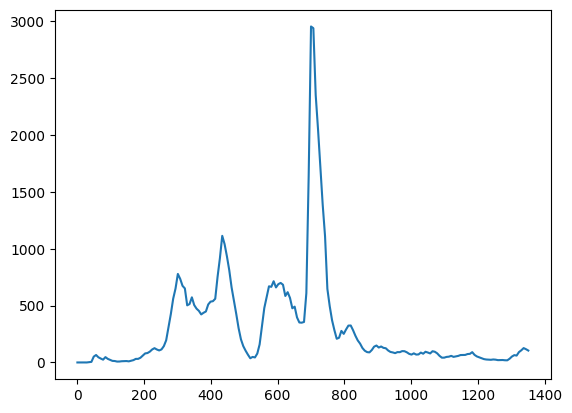

In [4]:
# Take the date column
T = A.date
# Convert it to dtype date
T = pd.to_datetime(T)
# Make it day number
base_date = T.min()
t = T.map(lambda date : (pd.Timestamp(date) - base_date).days )

# get the number of confirmed cases per day
Iobs = pd.to_numeric(A.avgcases_last7)

t = t.to_numpy()
Iobs = Iobs.to_numpy()
# Normalize S relative to exposed BC pop
Iobs = Iobs
# plot the number of active cases
plt.plot(t,Iobs)


We will try to model this data by using the SEIR model which reads

\begin{eqnarray}
\dot S &=& (\mu - \mu S - \beta S I) \\
\dot E &=& \beta S I - (\mu+a) E \\
\dot I &=& a E - (\mu+\gamma) I
\end{eqnarray}

Here $0\le S \le 1$ is the portion of the population that is susceptible to being sick, $0 \le E \le 1$ is the portion of exposed and $0 \le I \le 1$ the portion that are sick, which corresponds to the data that is measured.

The parameters $\mu, \beta, a$ and $\gamma$ are in general unknown. $\beta$ represents the interactions between sick and healthy people. This is the only parameter we can control by government regulations (e.g. masks closures etc). The rest of the parameters depends on the outbreak itself. If we can give a credible assessment for these parameters then we can change $\beta$ by changing the policy.

The mission is to estimate these parameters from the data and see if we can design a policy to reduce infections.


**The mission**

1. Write a code (class) that simulate the data given the parameters and some initial conditions.

2. Using the initial conditions
$$ S_0 = 0.99998, E_0 = 0.00001, I_0 = 0.00001 $$
and the parameters
$$ \beta  = 0.8, \gamma = 0.015,
\mu = 0.001,
a     = 0.105 $$
to model the system.

3. The observed data containes a number of peaks. Such solutions cannot be obtained with the proposed systems and constant parameters. Write a new code where the parameters are time dependent, that is, $\beta=\beta(t), \mu=\mu(t), \gamma=\gamma(t), a=a(t)$.

4. Keep $\beta(t) = constant$ and allow all other parameters to change in time. Write an optimizer that fits the data. Plot the observe and predicted and the parameters $\gamma, \mu, a$ as a function of time. Comment on your findings.

5. The large peak in the data represents a spike in cases when a new corona type hit. If you are in charge of policies, propose a range of $\beta$ that will flatten the curve.




Missions 1&2

In [24]:
class SEIRModel(nn.Module):
    def __init__(self, beta, gamma, a, mu, initial_conditions):
        super(SEIRModel, self).__init__()
        self.beta = beta
        self.gamma = gamma
        self.a = a
        self.mu = mu
        self.S, self.E, self.I = initial_conditions

    def forward(self, t):
        dSdt = self.mu - (self.mu * self.S) - (self.beta * self.S * self.I)
        dEdt = (self.beta * self.S * self.I) - ((self.mu + self.a) * self.E)
        dIdt = (self.a * self.E) - ((self.mu + self.gamma) * self.I)
        return torch.tensor([dSdt, dEdt, dIdt])

    def simulate(self, days):
        t = np.arange(0, days, 1)
        t = torch.tensor(t, dtype=torch.float32)
        S, E, I = [], [], []

        for i in range(days):
            derivatives = self.forward(t[i])
            self.S += derivatives[0].item()
            self.E += derivatives[1].item()
            self.I += derivatives[2].item()
            S.append(self.S)
            E.append(self.E)
            I.append(self.I)

        return t, torch.tensor(S), torch.tensor(E), torch.tensor(I)


beta = 0.8
gamma = 0.015
a = 0.105
mu = 0.001
initial_conditions = [0.99998, 0.00001, 0.00001]


seir_model = SEIRModel(beta, gamma, a, mu, initial_conditions)

# Simulate the SEIR model for a certain number of days
T = A.date
# Convert it to dtype date
T = pd.to_datetime(T)
# Make it day number
base_date = T.min()
t = T.map(lambda date: (pd.Timestamp(date) - base_date).days)
t = t.to_numpy()

days = len(t)

t, S, E, I = seir_model.simulate(days)


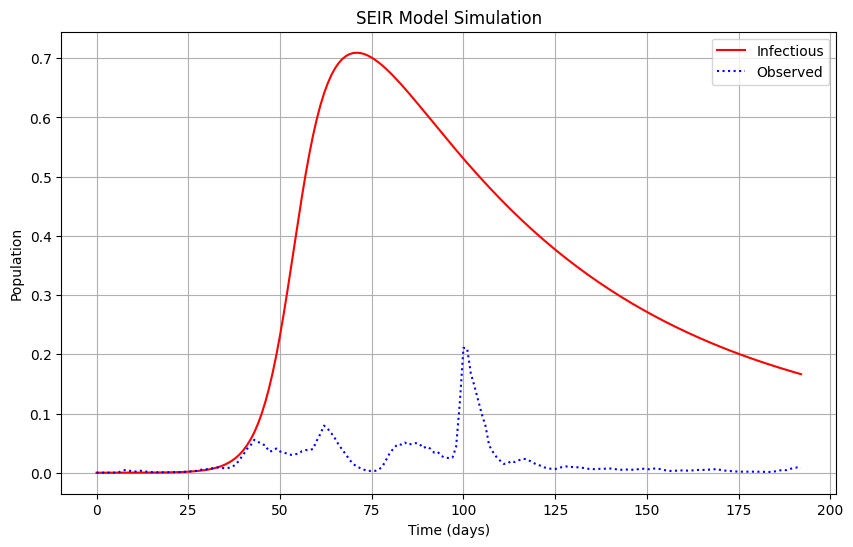

In [25]:

plt.figure(figsize=(10, 6))
# plt.plot(t, S, label='Susceptible', linestyle='--')
# plt.plot(t, E, label='Exposed', linestyle='-.')
plt.plot(t, I, label='Infectious', linestyle='-', color='red')
plt.plot(t, Iobs, label = 'Observed', linestyle='dotted', color = 'blue')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

Missions 3 - 5

In [19]:
Iobs = torch.tensor(Iobs, dtype=torch.float32, requires_grad=False)
n = Iobs[0]/1e-5
Iobs = Iobs/n
# Initial parameter values
num_iterations = 150
lr =  0.1
dt = 1

beta = 0.8

T = A.date
T = pd.to_datetime(T)
base_date = T.min()
t = T.map(lambda date: (pd.Timestamp(date) - base_date).days)
days = len(t)

# Create an optimizer for the time-dependent parameters

# Define the SEIR model
class SEIRModel(nn.Module):
    def __init__(self, S0, E0, I0, beta, dt, N):
        super(SEIRModel, self).__init__()
        self.gamma = nn.Parameter(torch.log(0.02*torch.ones(N-1, dtype=torch.float32)))
        self.mu = nn.Parameter(torch.log(0.001* torch.ones(N-1, dtype=torch.float32)))
        self.a = nn.Parameter(torch.log(0.105 * torch.ones(N-1, dtype=torch.float32)))
        self.beta = beta
        self.S =  torch.ones(N)
        self.E = torch.ones(N)
        self.I = torch.ones(N)

        self.S[0] = S0
        self.E[0] = E0
        self.I[0] = I0
        self.N = N

    def forward(self, i):
        mu_i = torch.exp(self.mu[i].clone())
        gamma_i = torch.exp(self.gamma[i].clone())
        a_i = torch.exp(self.a[i].clone())
        S_i = self.S[i].clone()
        I_i = self.I[i].clone()
        E_i = self.E[i].clone()
        dS = dt*(mu_i - (mu_i * S_i) - (self.beta * S_i * I_i))
        dE = dt*((self.beta * S_i * I_i) - ((mu_i + a_i) * E_i))
        dI = dt*((a_i * E_i) - ((mu_i + gamma_i) * I_i))
        self.S[i+1] = S_i + dS
        self.E[i+1] = E_i + dE
        self.I[i+1] = I_i + dI
        return

    def simulate(self):
        t = torch.arange(0, days, 1, dtype=torch.float32)

        for i in range(self.N-1):
            derivatives = self.forward(i)

        return t, self.S, self.E, self.I

# Simulate the SEIR model for a certain number of days


S0 = 0.99998
E0 = 0.00001
I0 = 0.00001

<ipython-input-19-5085b4e447ba>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Iobs = torch.tensor(Iobs, dtype=torch.float32, requires_grad=False)


iteration 0, loss = 4.22263728978578e-05
iteration 1, loss = 3.1933665013639256e-05
iteration 2, loss = 4.156598151894286e-05
iteration 3, loss = 1.966083436855115e-05
iteration 4, loss = 2.6951165637001395e-05
iteration 5, loss = 1.2179121767985635e-05
iteration 6, loss = 1.1687084224831779e-05
iteration 7, loss = 1.4451135939452797e-05
iteration 8, loss = 1.0136067430721596e-05
iteration 9, loss = 5.242861334409099e-06
iteration 10, loss = 8.370589966943953e-06
iteration 11, loss = 1.00584029496531e-05
iteration 12, loss = 5.640738891088404e-06
iteration 13, loss = 4.084121428604703e-06
iteration 14, loss = 6.249506895983359e-06
iteration 15, loss = 6.928851689735893e-06
iteration 16, loss = 4.7008115870994516e-06
iteration 17, loss = 3.4809672797564417e-06
iteration 18, loss = 5.112501185067231e-06
iteration 19, loss = 5.432256784843048e-06
iteration 20, loss = 3.5266155009594513e-06
iteration 21, loss = 2.834913857441279e-06
iteration 22, loss = 3.6407993775355862e-06
iteration 23,

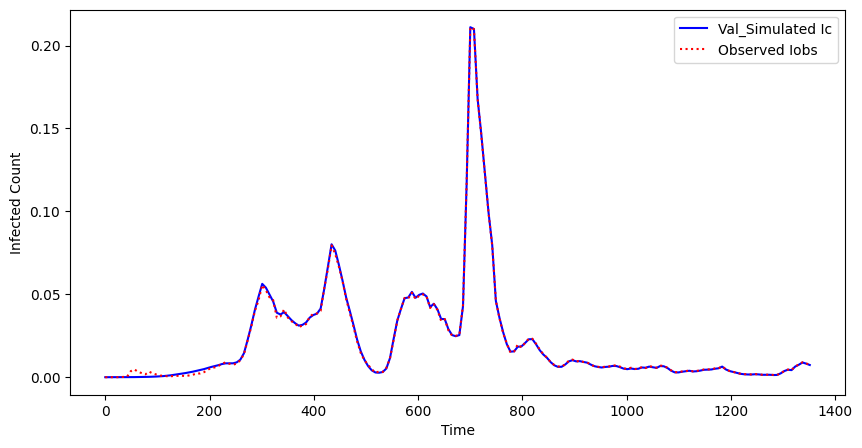

In [21]:
plt.figure(figsize=(10, 5))

#Instantiate model object
seir_model = SEIRModel(S0=S0, E0=E0, I0=I0, beta = beta, dt=dt, N=days)

#Model initially trained for 150 epochs and then reloaded and trained for 50 epohs
seir_model.load_state_dict(torch.load('/content/drive/MyDrive/seir_model.pth'))

optimizer = Adam(seir_model.parameters(), lr=lr)
for i in range(num_iterations):

    t, S, E, I = seir_model.simulate()

    loss = nn.MSELoss()(I, Iobs)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    print(f"iteration {i}, loss = {loss}")

print("done")

# Visualize Ic over time
plt.plot(7 * t, I.detach().numpy(), label='Val_Simulated Ic', color='blue')
plt.plot(7* t, Iobs.detach().numpy(), label='Observed Iobs', color='red', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Infected Count')
plt.legend()
plt.show()

#Same model
torch.save(seir_model.state_dict(), '/content/drive/MyDrive/seir_model.pth')




In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


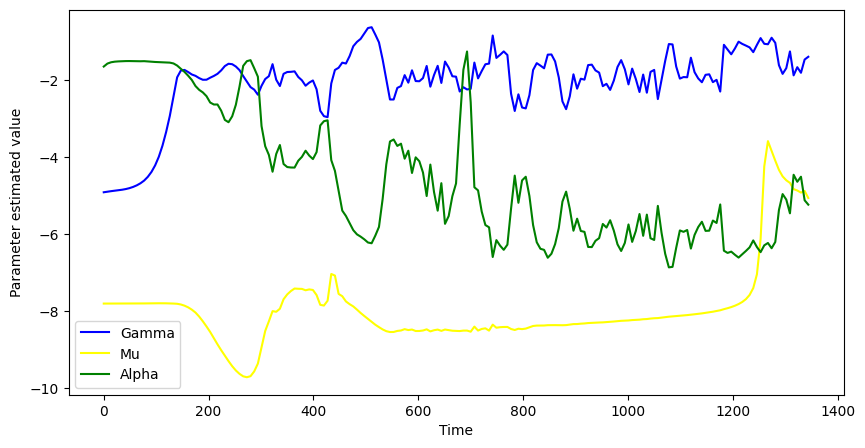

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(7 * t[:-1], seir_model.gamma.detach().numpy(), label='Gamma', color='blue')
plt.plot(7 * t[:-1], seir_model.mu.detach().numpy(), label='Mu', color='yellow')
plt.plot(7 * t[:-1], seir_model.a.detach().numpy(), label='Alpha', color='green')
#plt.plot(7* t, Iobs.detach().numpy(), label='Observed Iobs', color='red', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Parameter estimated value')
plt.legend()
plt.show()

Gamma increases with time: It implies that the rate at which individuals are recovering form the disease is faster. Either due to increased immunity or better healthcare intervention with time

Alpha decreases with time: It implies that the disease has a longer incubation time and so takes longer time for individuals to transition from exposed to infectious stage. This eventually, slows down rate of spread of the disease.

Mu decrease with time: Although there are dyas of increased population growth rate, there is a general decline in population growth. With a decrease in population, there is also a resultant decrease in th enumber of susceptible individuals.

Mission 5

done


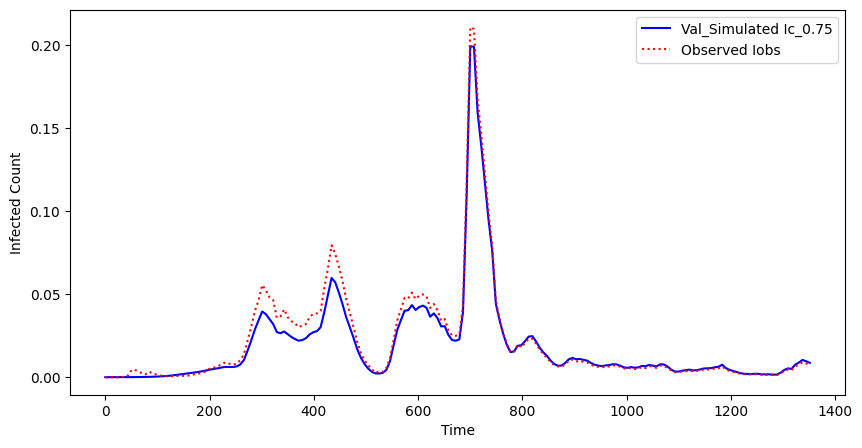

done


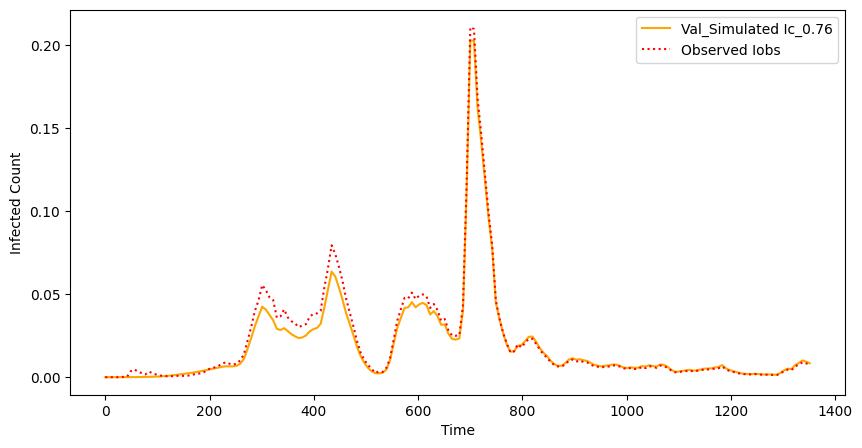

done


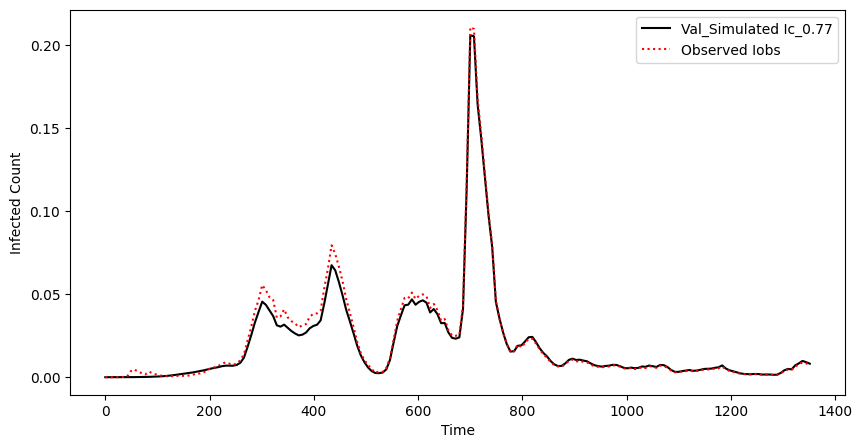

done


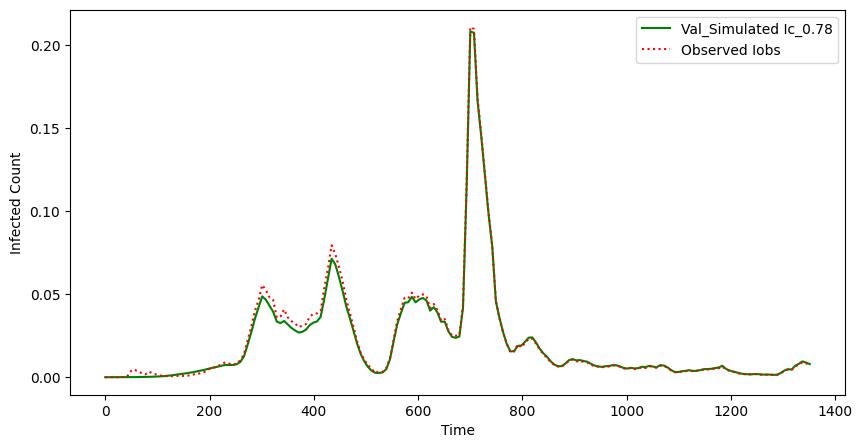

done


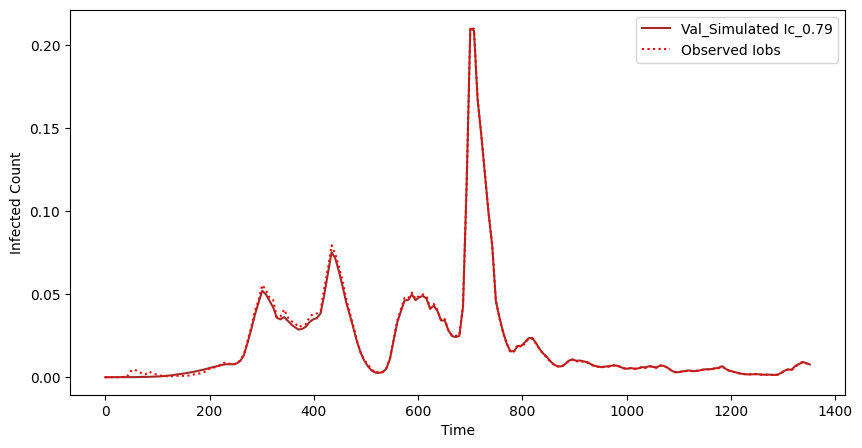

done


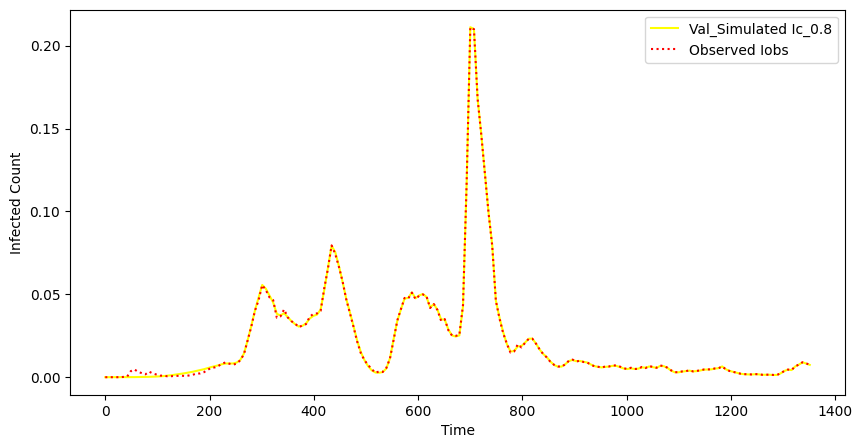

done


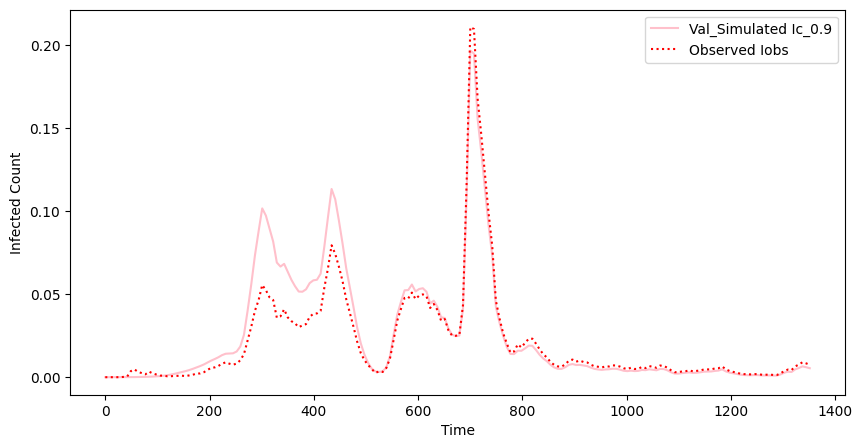

done


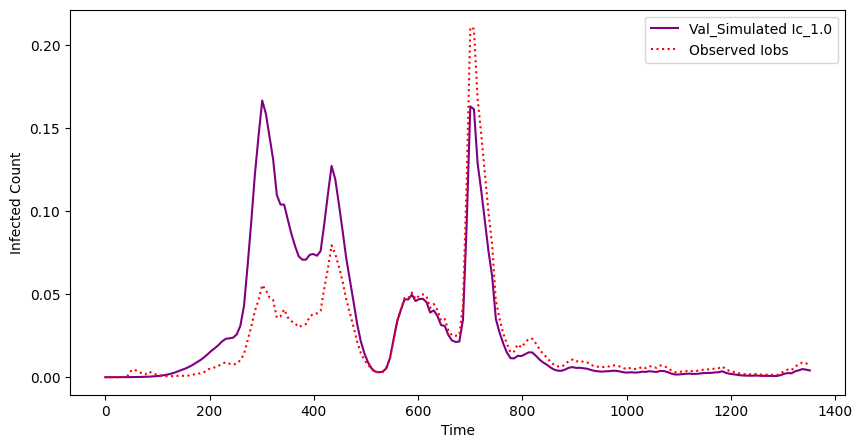

done


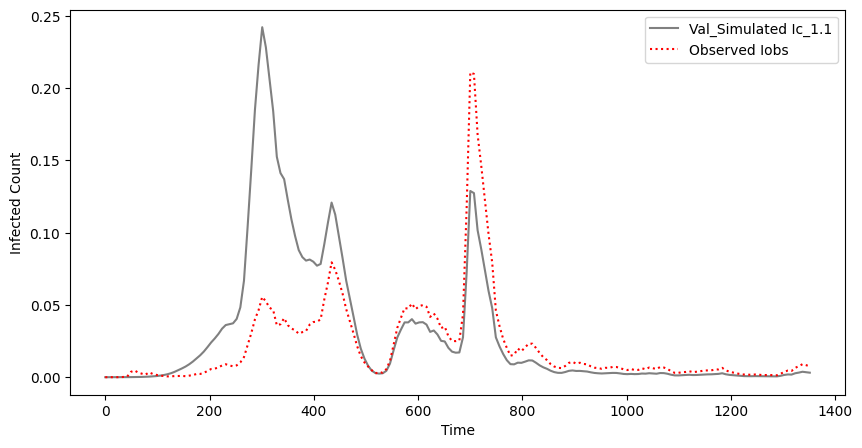

done


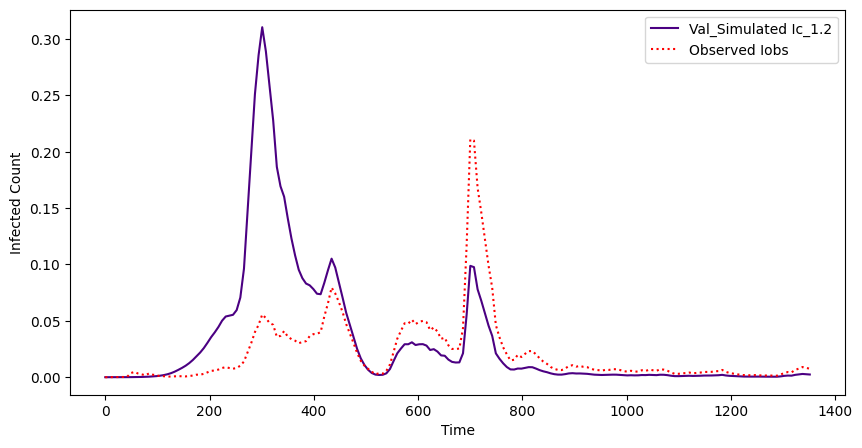

In [25]:
beta_list = [0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.9, 1.0, 1.1, 1.2]
colors = ['blue', 'orange', 'black', 'green', 'brown', 'yellow', 'pink', 'purple', 'gray', 'indigo']

# Perform parameter estimation
for j in range (len(beta_list)):
    seir_model = SEIRModel(S0=S0, E0=E0, I0=I0, beta=beta_list[j], dt=dt, N=days)
    seir_model.load_state_dict(torch.load('/content/drive/MyDrive/seir_model.pth'))
    optimizer = Adam(seir_model.parameters(), lr=lr)

    #for i in range(num_iterations):

    t, S, E, I = seir_model.simulate()


    print("done")
    # # Visualize Ic over time
    plt.figure(figsize=(10, 5))
    plt.plot(7 * t, I.detach().numpy(), label=f'Val_Simulated Ic_{beta_list[j]}', color=colors[j])
    plt.plot(7 * t, Iobs.detach().numpy(), label='Observed Iobs', color='red', linestyle='dotted')
    plt.xlabel('Time')
    plt.ylabel('Infected Count')
    plt.legend()
    plt.show()






Based on the above plots, it shows that beta within the range of (0.77, 0.79) flattens the curve. The approach used at arriving at this answer is: I optimised the values of gamma, mu and alpha at beta = 0.8 and saved the model. Then reloaded the saved model and kept gamma, mu and alpha constant while varying beta to investigate its effect on the curve. My consideration is to obtain the range of beta that closely fits the curve while flattening it eventually. Since beta = 0.8 was chosen as the beta to fit the observed curve, and the range of beta that fits the curve closely as well as flattening are less than 0.8, it follows that (in terms of policy making), laws that reduce transmission rate of the disease like social distancing, mask wearing, capping the number of people who crowd within an area will potentially control the spread of the disease.